# Итоговый проект

Для воспроизводимости результатов данного проекта необязательно запускать обучения нейронных сетей. Для полносвязной нейронной сети и для различных вариантов сверточных сетей сохранены веса. Вы можете запустить обучение этих моделей, но этот процесс займет какое-то время.

## Классификация изображений Fashion-MNIST

Импортируем библиотеки и истановим random seeds для возможности воспроизведения результатов. В качестве фреймворка будем использовать keras с бэкендом tensorflow. В данном случае, использование keras как отдельной библиотеки аналогичное tf.keras.

In [1]:
from tensorflow import set_random_seed
import keras
import pandas as pd
import numpy as np

set_random_seed(0)
np.random.seed(0)

path_to_test_data = 'fashion-mnist_test.csv'
path_to_train_data = 'fashion-mnist_train.csv'

Using TensorFlow backend.


Загрузим данные из csv-файлов. Выделим из тренировочных данных валидационную выборку.

In [2]:
def get_data(path_to_data):
    df = pd.read_csv(path_to_data)
    y = np.array(df['label'])
    X = df[df.columns[1:]].as_matrix()
    return X, y

X, y = get_data(path_to_train_data)
indices = list(range(len(X)))
np.random.seed(42)
np.random.shuffle(indices)
tr_i, te_i = indices[10000:], indices[:10000]
X_train, X_valid, y_train, y_valid = X[tr_i], X[te_i], y[tr_i], y[te_i]
X_test, y_test = get_data(path_to_test_data)

Приведем лейблы классов в one-hot представление и нормализуем признаки.

In [3]:
from keras import utils

y_train = utils.to_categorical(y_train)
y_valid = utils.to_categorical(y_valid)
y_test = utils.to_categorical(y_test)
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Логистическая регрессия

Реализуем логистическую регрессию. В качестве функции потерь будем использовать `categorical_crossentropy`.

In [4]:
from keras.models import Sequential
from keras.layers import Dense

def logistic_regression():
    model = Sequential()
    model.add(Dense(10, input_shape=(784,), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

Запустим обучение логистической регресии на 50 эпохах. Для построения графика зависимости метрики качества от количества эпох можно использовать tensorboard, который мы подключили в качестве callback.

Запуск tensorboard в терминале текущей директории: `tensorboard -logdir ./log/log_regr/`.

In [5]:
from keras.callbacks import TensorBoard

model = logistic_regression()
_ = model.fit(X_train, y_train, epochs=100, 
              validation_data=(X_valid, y_valid),
              verbose=0,
              callbacks=[TensorBoard('./logs/log_regr/')])

Качество логистической регрессии на тестовой выборке после 50 эпох приведено ниже.

Logistic Regression, score: 0.856


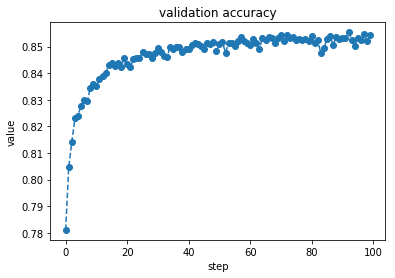

In [6]:
from matplotlib import pyplot as plt

_, score = model.evaluate(X_test, y_test, verbose=0)
print("Logistic Regression, score: {0:.3f}".format(score))

df = pd.read_csv('plot_data.csv')
x, y = df[['Step']].as_matrix(), df[['Value']].as_matrix()
plt.title('validation accuracy')
plt.xlabel('step')
plt.ylabel('value')
plt.plot(x, y, '--o')
plt.show()

## Полносвязная нейронная сеть

Реализуем полносвязную сверточную сеть с несколькими скрытыми слоями. В качестве оптимизатора будем использовать Adam.

In [7]:
def get_neural_network():
    model = Sequential()
    model.add(Dense(128, input_shape=(784,), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = get_neural_network()

Запустим обучение нейронной сети на тренировочной выборке в течение 30 эпох. По-мимо `TensorBoard` callback, подключим `ModelCheckpoint` для сохранения лучшего состояния сети в процессе обучения с точки зрения лучшего качества на валидационной выборке.

### *Обучение полносвязной нейронной сети*

In [8]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('nn.h5', 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   mode='max',
                                   monitor='val_acc')
_ = model.fit(X_train, y_train, epochs=30, 
              validation_data=(X_valid, y_valid),
              verbose=0,
              callbacks=[model_checkpoint, TensorBoard('./logs/nn/')])

Загрузим веса, соответствующие лучшему состоянию нейронной сети. Оценим качество на тестовой выборке. В результате, оно примерно на 4% выше, чем для логистической регрессии. Это можно объяснить тем, что полносвязная нейронная сеть по своей сути является нелинейной моделью, которая может автоматически извлекать признаки из предложенных данных.

In [9]:
model.load_weights('nn.h5')
_, score = model.evaluate(X_test, y_test, verbose=0)
print("Fully-Connected neural network, score: {0:.3f}".format(score))

Fully-Connected neural network, score: 0.897


## Сверточная нейронная сеть

Изменим размерность тренировочных и тестовых данных для сверточной нейронной сети.

In [10]:
X_train = X_train.reshape(50000, 28, 28, 1)
X_valid = X_valid.reshape(10000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

Сверточная нейронная сеть для решения задачи классификации приведена ниже.

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def get_conv_net():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = get_conv_net()

Обучим сверточную нейронную сеть.

### *Обучение сверточной нейронной сети*

In [12]:
model_checkpoint = ModelCheckpoint('cnn-1.h5', 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   mode='max',
                                   monitor='val_acc')
_ = model.fit(X_train, y_train, epochs=15, 
              validation_data=(X_valid, y_valid),
              verbose=0,
              callbacks=[model_checkpoint, TensorBoard('./logs/cnn-1/')])

В результате, качество сверточные нейронной сети на тестовых данных примерно на 2% процента выше полносвязной нейронной сети.

In [13]:
model.load_weights('cnn-1.h5')
_, score = model.evaluate(X_test, y_test, verbose=0)
print("cnn 1, params: %d" % model.count_params())
print("cnn 1, score: {0:.3f}".format(score))

cnn 1, params: 228202
cnn 1, score: 0.914


Попробуем сделать нашу сверточную нейронную сеть немного глубже. Для этого добавим несколько сверточных слоев.

In [14]:
def get_another_conv_net(optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = get_another_conv_net()

### *Обучение сверточной нейронной сети*

In [15]:
model_checkpoint = ModelCheckpoint('cnn-2.h5', 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   mode='max',
                                   monitor='val_acc')
_ = model.fit(X_train, y_train, epochs=15, 
              validation_data=(X_valid, y_valid),
              verbose=0,
              callbacks=[model_checkpoint, TensorBoard('./logs/cnn-2/')])

В результате, качество модели на тестовых данных стало немного лучше.

In [16]:
model.load_weights('cnn-2.h5')
_, score = model.evaluate(X_test, y_test, verbose=0)
print("cnn 2, params: %d" % model.count_params())
print("cnn 2, score: {0:.3f}".format(score))

cnn 2, params: 200650
cnn 2, score: 0.921


Добавим Batch Normalization слои в нашу модель после сверточных слоев. Запустим обучение модели.

In [17]:
from keras.layers import BatchNormalization

def get_conv_net_with_batch_norm(optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = get_conv_net_with_batch_norm()

### *Обучение сверточной нейронной сети*

In [18]:
model_checkpoint = ModelCheckpoint('cnn-3.h5', 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   mode='max',
                                   monitor='val_acc')
_ = model.fit(X_train, y_train, epochs=15, 
              validation_data=(X_valid, y_valid),
              verbose=0,
              callbacks=[model_checkpoint, TensorBoard('./logs/cnn-3/')])

В результате, мы смогли немного улучшить качество сверточной нейронной сети на тестовых данных.

In [19]:
model.load_weights('cnn-3.h5')
_, score = model.evaluate(X_test, y_test, verbose=0)
print("cnn 3, params: %d" % model.count_params())
print("cnn 3, score: {0:.3f}".format(score))

cnn 3, params: 201418
cnn 3, score: 0.928
